# 2.0 Exploratory Data Analysis

Contents

*  ## [2.1 Introduction](#2.1)
    
    * ### [2.1.1 Problem Recap](#2.1.1)
    * ### [2.1.2 Notebook Goals](#2.1.2)


*  ## [2.2 Load data](#2.2)

    * ### [2.2.1 Imports](#2.2.1)
    * ### [2.2.2 Fashion Dataset](#2.2.2)
    

*  ## [2.3 Explore the data](#2.3)
    
    * ### [2.3.1 Missing Values](#2.3.1)
    * ### [2.3.2 Examining Star Counts](#2.3.2)
    * ### [2.3.3 Creating Target Feature](#2.3.3)
    * ### [2.3.4 Examine Review Lengths](#2.3.4)

## 2.1 Introduction <a name="2.1"></a>

### 2.1.1 Problem Recap <a name="2.1.1"></a>

Using customer text data about amazon products, we will build, evaluate and compare models to estimate the probability that a given text review can be classified as “positive” or “negative”.

Our goal is to build a text classifier using Amazon product review data which can be used to analyze customer sentiment which does not have accompanying numeric data.

### 2.1.2 Notebook Goals<a name = "2.1.2"></a>

In this notebook, we will be doing EDA (exploratory data analysis) to examine the shape of our data, its features, missing values, distributions, and any other relevant information.

1. Look for any mistakes with our data collection and data wrangling.

2. Look at relationships between the different features.

3. Look at our target feature.

4. Clean our data of non-letter characters

## 2.2 Load the Data <a name="2.2"></a>

### 2.2.1 Imports <a name="2.2.1"></a>

In [50]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from math import log, e
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

ModuleNotFoundError: No module named 'nltk'

### 2.2.2 Load Fashion Data <a name="2.2.2"></a>

In [2]:
df = pq.read_table("../data/edited/fashion0.parquet")
fashion = df.to_pandas()
fashion.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime
0,5,True,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,perfect replacements!!,1413763200
1,2,True,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400
2,4,False,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800
3,2,True,A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400
4,3,False,A89F3LQADZBS5,7106116521,Okay,Three Stars,1406419200


## 2.3 Explore the Data <a name="2.3"></a>

### 2.3.1 Missing Values <a name="2.3.1"><a/>

We don't have many missing values for reviews so we will drop them.

In [53]:
print(fashion.isna().sum())
fashion.dropna(inplace=True)

overall           0
verified          0
reviewerID        0
asin              0
reviewText        0
summary           0
unixReviewTime    0
negativity        0
review_length     0
dtype: int64


Looking at our target column

In [5]:
fashion["overall"].info()

<class 'pandas.core.series.Series'>
Int64Index: 881900 entries, 0 to 883635
Series name: overall
Non-Null Count   Dtype
--------------   -----
881900 non-null  int64
dtypes: int64(1)
memory usage: 13.5 MB


In [6]:
fashion["overall"].describe()

count    881900.000000
mean          3.906144
std           1.418443
min           1.000000
25%           3.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

### 2.3.2 Examining Star Counts <a name="2.3.2"><a/>

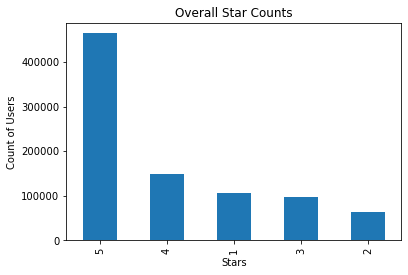

In [7]:
fashion["overall"].value_counts().plot.bar()
plt.title("Overall Star Counts")
plt.xlabel("Stars")
plt.ylabel("Count of Users")
plt.show();

Our dataset is largely positive reviews. Even combining the 1-3 as negative and the 4-5 as positive, we'll still have a bit of imbalance that we'll need to be aware of.

In [8]:
fashion.shape

(881900, 7)

In [9]:
fashion.drop_duplicates(subset=["overall", "reviewText", "asin", "reviewerID"], inplace=True)
fashion.shape

(874378, 7)

In [10]:
stars = ["One Star", "Two Stars", "Three Stars", "Four Stars", "Five Stars"]

nums = [1,2,3,4,5]

A number of review summaries are explicitly "X stars". Let's take a look at the actual score given for them

In [11]:
for s,n in zip(stars, nums):
    partial_df = fashion[fashion["summary"]==s]
    print(f"Number of '{s}' review summaries:", len(partial_df), "\n")
    
    print("Segmented by")
    print(partial_df.groupby("overall")["overall"].count())

Number of 'One Star' review summaries: 34367 

Segmented by
overall
1    34275
2       13
3       23
4       22
5       34
Name: overall, dtype: int64
Number of 'Two Stars' review summaries: 19823 

Segmented by
overall
1       52
2    19703
3       22
4       21
5       25
Name: overall, dtype: int64
Number of 'Three Stars' review summaries: 29908 

Segmented by
overall
1       21
2       22
3    29781
4       41
5       43
Name: overall, dtype: int64
Number of 'Four Stars' review summaries: 45717 

Segmented by
overall
1       18
2       24
3       28
4    45537
5      110
Name: overall, dtype: int64
Number of 'Five Stars' review summaries: 173898 

Segmented by
overall
1        43
2        13
3        39
4        54
5    173749
Name: overall, dtype: int64


Look at word counts and visualize them for the review text by star count. The word cloud library automatically removes stop words for us to give is more meaningful visualizations. We'll have to do this manually later to clean the data.

1.00 Small
0.81 Fit
0.78 Size
0.56 Look
0.49 Ordered
0.48 Way
0.44 Picture


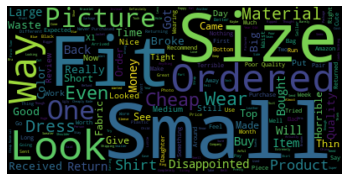

1.00 Small
0.93 Fit
0.92 Size
0.63 Look
0.53 One
0.50 Way
0.49 Wear


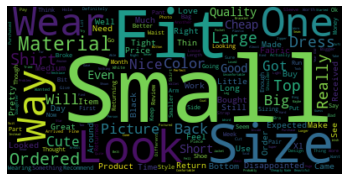

1.00 Fit
0.93 Size
0.86 Small
0.61 Look
0.49 Wear
0.45 One
0.43 Cute


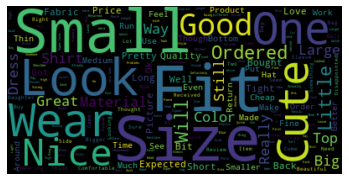

1.00 Fit
0.76 Size
0.59 Great
0.57 Nice
0.56 Love
0.51 Good
0.50 Wear


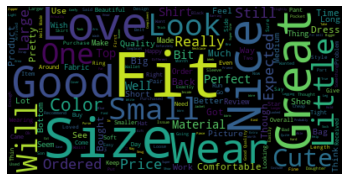

1.00 Love
0.60 Fit
0.54 Great
0.38 Wear
0.36 Size
0.33 Perfect
0.33 Nice


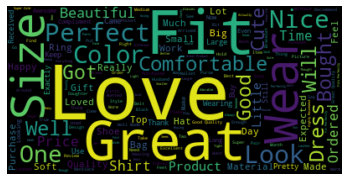

In [12]:
 for n in range(1,6):
    text = ' '.join(fashion[fashion["overall"]==n].sample(3000)["reviewText"].dropna().str.title().values)

    wc = WordCloud()
    wc.stopwords.add("i")
    wc.generate(text)

    for each_tuple in list(wc.words_.items())[0:7]:
        word, pct = each_tuple
        print("{:.2f}".format(pct), word)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Looking at the visualization, there seems to be clear similarities between 4-5 and 1-3 star review texts. We'll create that column now. We will code reviews as 1 for negativity if the score is 3 or less.

### 2.3.3 Create Target Feature as Boolean <a name="2.3.3"><a/>

In [13]:
fashion["negativity"] = fashion["overall"].apply(lambda x: 1 if x <= 3 else 0)


In [14]:
fashion.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negativity
0,5,True,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,perfect replacements!!,1413763200,0
1,2,True,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,1
2,4,False,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,0
3,2,True,A2UH2QQ275NV45,7106116521,too tiny an opening,Two Stars,1408838400,1
4,3,False,A89F3LQADZBS5,7106116521,Okay,Three Stars,1406419200,1


1.00 Love
0.51 Wear
0.34 Bought
0.31 Ordered
0.30 Comfortable
0.29 Fit
0.29 Size


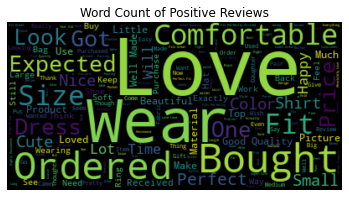

1.00 Small
0.71 Fit
0.57 Wear
0.56 Ordered
0.56 Look
0.52 Size
0.51 Way


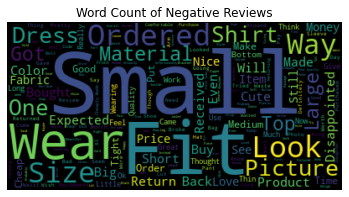

In [15]:
for n in range(0,2):
    text = ' '.join(fashion[fashion["negativity"]==n]["reviewText"].str.title().values)

    wc = WordCloud()
    wc.stopwords.add("i")
    wc.generate(text)

    for each_tuple in list(wc.words_.items())[0:7]:
        word, pct = each_tuple
        print("{:.2f}".format(pct), word)
    
    
    
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    if n == 0:
        plt.title("Word Count of Positive Reviews")
    else:
        plt.title("Word Count of Negative Reviews")
    plt.show()

### 2.3.4 Examine Review Lengths <a name="2.3.4"><a/>

In [16]:
fashion["review_length"] = fashion["reviewText"].apply(lambda x: len(x.split(' ')))

In [17]:
fashion["review_length"].describe()

count    874378.000000
mean         28.639243
std          38.733394
min           1.000000
25%           7.000000
50%          17.000000
75%          35.000000
max        2088.000000
Name: review_length, dtype: float64

In [18]:
fashion[fashion.review_length>=1000]

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negativity,review_length
23346,4,True,A3PMNUBMNX9P5J,B000PMKBL6,"As a woman, most of us have multiple pairs of ...",Great- depending on the type of boot.,1487548800,0,1162
24519,5,True,A36O3OTEKIX4U7,B000UJA696,I have had the M65 Field Jacket for about 5 we...,M65 Field Jacket with ALS liner,1422748800,0,1283
34025,5,True,A15NN5SM9DSONL,B0014JDIW8,(I purchased this under my wife's login.)\n\nI...,Something I'm happy to carry!,1375488000,0,1256
55649,5,False,A3VCTYH93B5E2V,B000UJDPHQ,I am a M-65 junkie / collector. I currently ow...,Alpha v. Propper v. Rothco,1241740800,0,1161
55863,5,True,A36O3OTEKIX4U7,B000UJDPHQ,I have had the M65 Field Jacket for about 5 we...,M65 Field Jacket with ALS liner,1422748800,0,1283
219191,4,True,A30JYY7WWK4MOU,B00NR1Y30C,Just got my corset in the mail today! I have a...,great for the price range!,1432598400,0,1076
286754,5,True,A20UQDUH2J0B6W,B00ZOWJI7A,I received my Amazon order for two of these ch...,Just what I need.,1493683200,0,1226
433455,4,False,AYRGN7W7BDD34,B0090US1WU,I bought this watch directly from Sea-Gull's U...,Excellent watch for the price - a couple of flaws,1352419200,0,1111
488825,4,True,A1BSIVAPDRNAH2,B00H8AG1WQ,I write this review with tremendous conflict.\...,Useful if you don't wear underwear or use the ...,1523404800,0,1143
519065,4,True,A3MNMPRLQBSS5J,B00K8UVPM4,I purchased the Microfiber Organizer Cover wi...,"Nice Organizer Cover, but read my review about...",1509753600,0,1390


#### Examine longer reviews to see distribution of ratings

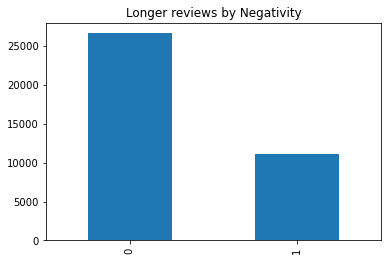

In [19]:
fashion[fashion["review_length"]>100]["negativity"].value_counts().sort_index().plot.bar()
plt.title("Longer reviews by Negativity");

We see more long reviews are positive than negative with about 35,000 reviews over 1000 words long. This is pretty reflective of the distribution of positive/negative reviews in our data.

In [20]:
fashion["negativity"].sum()/len(fashion["negativity"])

0.3047938077124539

Roughly 30% of the total reviews are negative (1).

#### Examine Shorter reviews to see distribution of ratings

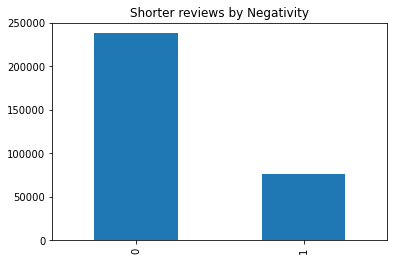

In [21]:
fashion[fashion["review_length"]<=10]["negativity"].value_counts().sort_index().plot.bar()
plt.title("Shorter reviews by Negativity");

<AxesSubplot:ylabel='Frequency'>

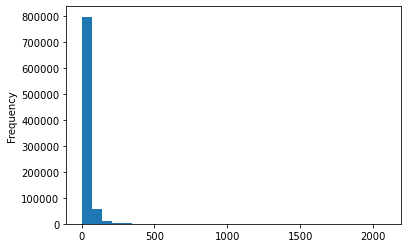

In [22]:
fashion.review_length.plot.hist(bins=30)

In [23]:
fashion.review_length.describe()

count    874378.000000
mean         28.639243
std          38.733394
min           1.000000
25%           7.000000
50%          17.000000
75%          35.000000
max        2088.000000
Name: review_length, dtype: float64

The mean review length is just under 30 words long but we have a high standard deviation because of the relatively sparse, extremely long reviews.

High, sparse values are skewing our bins. Review length is strongly right-skewed. Most of our reviews are at the low end of word count.

In [24]:
log_transformed_length = fashion["review_length"].apply(lambda x: np.log(x))

log_transformed_length.describe()


count    874378.000000
mean          2.715086
std           1.200307
min           0.000000
25%           1.945910
50%           2.833213
75%           3.555348
max           7.643962
Name: review_length, dtype: float64

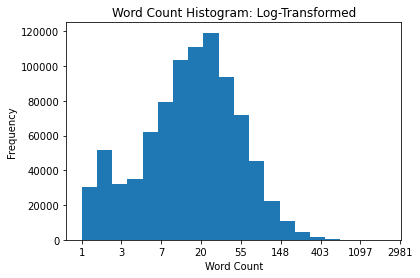

In [25]:
log_transformed_length.plot.hist(bins=20)
plt.title("Word Count Histogram: Log-Transformed")
plt.xticks(range(9), labels=[round(e**x) for x in range(9)]) #set actual word counts for x-axis labels
plt.xlabel("Word Count");

We see the bulk of reviews are between 5-100 words but there are also far more reviews under 5 words than over 150 words.

## 2.4 Text Cleaning <a name="2.4"><a/>

### 2.4.1  Removing numbers and punctuation <a name="2.4.1"></a>

In [27]:
import re

pattern = re.compile(r"[^A-Za-z ]+")

In [26]:
fashion["reviewText"] = fashion.reviewText.str.lower()

In [49]:
pd.Series(["Wh375at*&", "the#*234@#$", r"%$heck(*&(*&#$||))"]).str.replace(pattern, " ", regex=True)

0    Wh at 
1      the 
2     heck 
dtype: object

In [29]:
fashion["reviewText"] = fashion.reviewText.str.replace(pattern, " ", regex=True)

In [30]:
for char in list("!@#%^&*(){}|_+="):
    if fashion.reviewText.str.contains(char, regex=False).sum() == 0:
        print(f"{char} not found in review text.")

! not found in review text.
@ not found in review text.
# not found in review text.
% not found in review text.
^ not found in review text.
& not found in review text.
* not found in review text.
( not found in review text.
) not found in review text.
{ not found in review text.
} not found in review text.
| not found in review text.
_ not found in review text.
+ not found in review text.
= not found in review text.


In [31]:
fashion.reviewText.str.contains("  ").sum()

619358

There are multiple spaces between words now due to replacing punctuation. We'll change these to single spaces.

In [32]:
fashion["reviewText"] = fashion.reviewText.str.replace(" +", " ", regex=True)

In [33]:
fashion.reviewText.str.contains("  ").sum()

0

In [57]:
fashion.head()

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negativity,review_length
0,5,True,A1D4G1SNUZWQOT,7106116521,exactly needed,perfect replacements!!,1413763200,0,4
1,2,True,A3DDWDH9PX2YX2,7106116521,agree review opening small bent hook expensive...,"I agree with the other review, the opening is ...",1411862400,1,48
2,4,False,A2MWC41EW7XL15,7106116521,love going order pack work including losing ea...,My New 'Friends' !!,1408924800,0,48
3,2,True,A2UH2QQ275NV45,7106116521,tiny opening,Two Stars,1408838400,1,4
4,3,False,A89F3LQADZBS5,7106116521,okay,Three Stars,1406419200,1,1


### 2.4.2 Removing stop words

Stop words which don't have significant meaning for the text will give us noisy data and worse predictions. We'll quickly remove those.

In [34]:
for i, word in enumerate(STOP_WORDS):
    print(word, end="\t")

everywhere	‘re	do	eleven	still	should	does	upon	to	even	made	among	fifteen	herself	own	beforehand	several	sixty	were	whence	regarding	put	in	became	they	else	between	through	only	whether	who	first	up	whose	around	‘d	serious	with	give	n‘t	've	’ll	myself	whereupon	's	again	hereby	please	often	which	out	afterwards	when	have	using	beyond	if	ca	further	therefore	across	never	perhaps	‘ve	thereby	‘ll	either	somewhere	show	back	me	him	although	forty	thence	n't	onto	per	over	others	beside	there	any	or	anyhow	than	nowhere	as	becoming	toward	last	us	every	unless	same	an	why	're	everyone	whoever	very	'm	once	bottom	at	’d	did	mine	too	see	and	top	thereupon	so	are	off	hereupon	we	re	thereafter	under	almost	most	whither	rather	cannot	being	seems	five	’s	neither	may	one	within	empty	your	elsewhere	always	amount	three	its	since	say	anyway	that	‘m	'd	along	namely	sometime	towards	except	least	twenty	less	twelve	i	seemed	about	could	whenever	sometimes	moreover	herein	done	our	be	yourselves	for	of	six	bee

In [35]:
#split the reviews into separate word list, check if they are stop words, then rejoin into a string
fashion["reviewText"] = fashion.reviewText.apply(lambda sent: " ".join([word for word in sent.split() if word not in STOP_WORDS]).strip())

Let's check if we have any empty reviews after remove punctuation and stop words.

In [36]:
fashion[fashion.reviewText == '']

,overall,verified,reviewerID,asin,reviewText,summary,unixReviewTime,negativity,review_length
340,5,True,A3AKIOL17AW7Y4,B00062NHH0,,Five Stars,1456790400,0,4
386,5,True,A2AFZG45B85CT1,B00062NHH0,,Five Stars,1440201600,0,1
415,4,True,A2KCQQJ0CG7Y4S,B00062NHH0,,Four Stars,1431561600,0,2
427,5,True,A11DNVHRYUDZA3,B00062NHH0,,Five Stars,1429747200,0,1
451,5,True,A1SWMU4E01EWKU,B00062NHH0,,Five Stars,1426723200,0,2
...,...,...,...,...,...,...,...,...,...
880321,2,True,A2MOJNM33EZ1RA,B01HBLV5F4,,Two Stars,1475107200,1,4
880444,5,True,A3IN8QA6VV1BDS,B01HBY1NS0,,Five Stars,1484179200,0,1
881520,5,True,A3K7ECEGMQZDQL,B01HEB0E1C,,Five Stars,1483747200,0,2
882511,2,False,ALFL5XF087Y92,B01HGQRLAM,,Two Stars,1472342400,1,1


Let's drop those.

In [37]:
fashion = fashion[~(fashion.reviewText == '')]

In [38]:
cleaned_data = fashion.drop(columns=["verified", "reviewerID", "unixReviewTime", "asin"])

## 2.5 Save the data

In [39]:
cleaned_data.to_parquet("../data/edited/fashion.parquet")

## 2.6 Conclusions <a name="2.6"><a/>

### 2.6.1 Summary <a name="2.6.1"><a/>

### 2.6.2 Next steps <a name="2.6.2"><a/>